In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
import geocoder
import os
import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline


print('Libraries imported.')

Libraries imported.


In [3]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [48]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'RA3ZILNY0Q1AHOHRVI4WGYJYIXMGJ5SIQ12MDLHNVHRBNWGO' # your Foursquare ID
    CLIENT_SECRET = 'JDK1MKNAW5ALILR4KO5NELUPMDDB51SY1WPPSCZFASXPRURY' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


In [49]:

def get_venue_details(venue_id):
        
    CLIENT_ID = 'RA3ZILNY0Q1AHOHRVI4WGYJYIXMGJ5SIQ12MDLHNVHRBNWGO' # your Foursquare ID
    CLIENT_SECRET = 'JDK1MKNAW5ALILR4KO5NELUPMDDB51SY1WPPSCZFASXPRURY' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [50]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [51]:
new_york_data=get_new_york_data()

new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [52]:
new_york_data.shape

(306, 4)

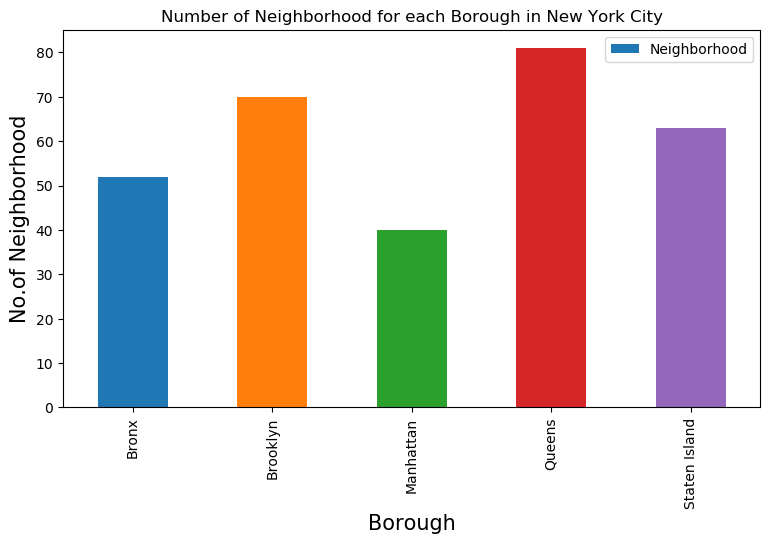

In [53]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [55]:
column_names=['Borough', 'Neighborhood', 'ID','Name']
chinese_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    chinese_resturants=venues[venues['Category']=='Chinese Restaurant']   
    print('(',count,'/',len(new_york_data),')','Chinese Resturants in '+Neighborhood+', '+Borough+':'+str(len(chinese_resturants)))
    for resturant_detail in chinese_resturants.values.tolist():
        id, name , category=resturant_detail
        chinese_rest_ny = chinese_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Chinese Resturants in Wakefield, Bronx:2
( 2 / 306 ) Chinese Resturants in Co-op City, Bronx:2
( 3 / 306 ) Chinese Resturants in Eastchester, Bronx:0
( 4 / 306 ) Chinese Resturants in Fieldston, Bronx:1
( 5 / 306 ) Chinese Resturants in Riverdale, Bronx:1
( 6 / 306 ) Chinese Resturants in Kingsbridge, Bronx:1
( 7 / 306 ) Chinese Resturants in Marble Hill, Manhattan:1
( 8 / 306 ) Chinese Resturants in Woodlawn, Bronx:0
( 9 / 306 ) Chinese Resturants in Norwood, Bronx:2
( 10 / 306 ) Chinese Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) Chinese Resturants in Baychester, Bronx:3
( 12 / 306 ) Chinese Resturants in Pelham Parkway, Bronx:4
( 13 / 306 ) Chinese Resturants in City Island, Bronx:1
( 14 / 306 ) Chinese Resturants in Bedford Park, Bronx:2
( 15 / 306 ) Chinese Resturants in University Heights, Bronx:1
( 16 / 306 ) Chinese Resturants in Morris Heights, Bronx:3
( 17 / 306 ) Chinese Resturants in Fordham, Bronx:1
( 18 / 306 ) Chinese Resturants in East Tremont, Bronx:

( 141 / 306 ) Chinese Resturants in Sunnyside, Queens:3
( 142 / 306 ) Chinese Resturants in East Elmhurst, Queens:0
( 143 / 306 ) Chinese Resturants in Maspeth, Queens:3
( 144 / 306 ) Chinese Resturants in Ridgewood, Queens:2
( 145 / 306 ) Chinese Resturants in Glendale, Queens:0
( 146 / 306 ) Chinese Resturants in Rego Park, Queens:2
( 147 / 306 ) Chinese Resturants in Woodhaven, Queens:2
( 148 / 306 ) Chinese Resturants in Ozone Park, Queens:2
( 149 / 306 ) Chinese Resturants in South Ozone Park, Queens:3
( 150 / 306 ) Chinese Resturants in College Point, Queens:2
( 151 / 306 ) Chinese Resturants in Whitestone, Queens:1
( 152 / 306 ) Chinese Resturants in Bayside, Queens:0
( 153 / 306 ) Chinese Resturants in Auburndale, Queens:1
( 154 / 306 ) Chinese Resturants in Little Neck, Queens:6
( 155 / 306 ) Chinese Resturants in Douglaston, Queens:6
( 156 / 306 ) Chinese Resturants in Glen Oaks, Queens:0
( 157 / 306 ) Chinese Resturants in Bellerose, Queens:1
( 158 / 306 ) Chinese Resturants

( 276 / 306 ) Chinese Resturants in Stuyvesant Town, Manhattan:1
( 277 / 306 ) Chinese Resturants in Flatiron, Manhattan:1
( 278 / 306 ) Chinese Resturants in Sunnyside Gardens, Queens:0
( 279 / 306 ) Chinese Resturants in Blissville, Queens:3
( 280 / 306 ) Chinese Resturants in Fulton Ferry, Brooklyn:0
( 281 / 306 ) Chinese Resturants in Vinegar Hill, Brooklyn:0
( 282 / 306 ) Chinese Resturants in Weeksville, Brooklyn:2
( 283 / 306 ) Chinese Resturants in Broadway Junction, Brooklyn:1
( 284 / 306 ) Chinese Resturants in Dumbo, Brooklyn:0
( 285 / 306 ) Chinese Resturants in Manor Heights, Staten Island:2
( 286 / 306 ) Chinese Resturants in Willowbrook, Staten Island:1
( 287 / 306 ) Chinese Resturants in Sandy Ground, Staten Island:0
( 288 / 306 ) Chinese Resturants in Egbertville, Staten Island:0
( 289 / 306 ) Chinese Resturants in Roxbury, Queens:0
( 290 / 306 ) Chinese Resturants in Homecrest, Brooklyn:3
( 291 / 306 ) Chinese Resturants in Middle Village, Queens:2
( 292 / 306 ) Chine

In [56]:
chinese_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Wakefield,4edbac4e775bcc53fc0ed5f8,Hong Kong China King
1,Bronx,Wakefield,4c3de66616ca95215b17bc7f,Dragon Star Chinese Food
2,Bronx,Co-op City,4e4df7abbd4101d0d79f476b,China Top
3,Bronx,Co-op City,4c66dcfaaebea593955a74d0,Chinese Buffet
4,Bronx,Fieldston,4f5543a7e4b0ac8e5378b9de,Broadway Chinese Kitchen


In [57]:
chinese_rest_ny.shape

(407, 4)

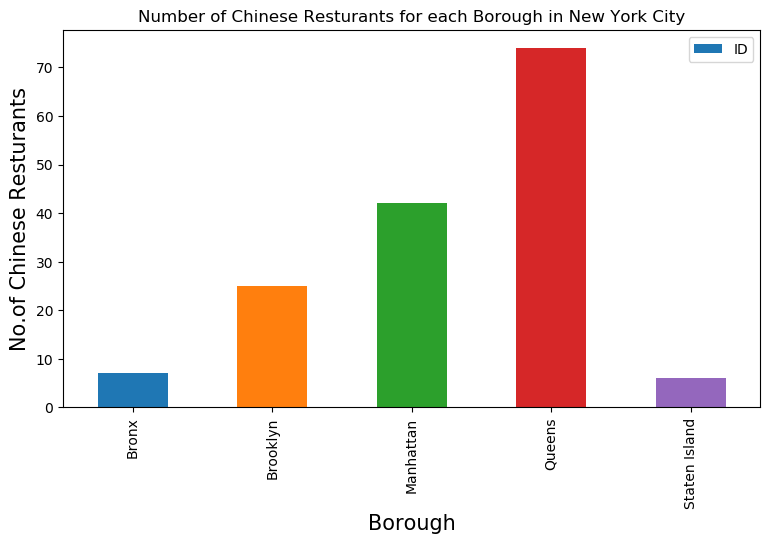

In [58]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Chinese Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Chinese Resturants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

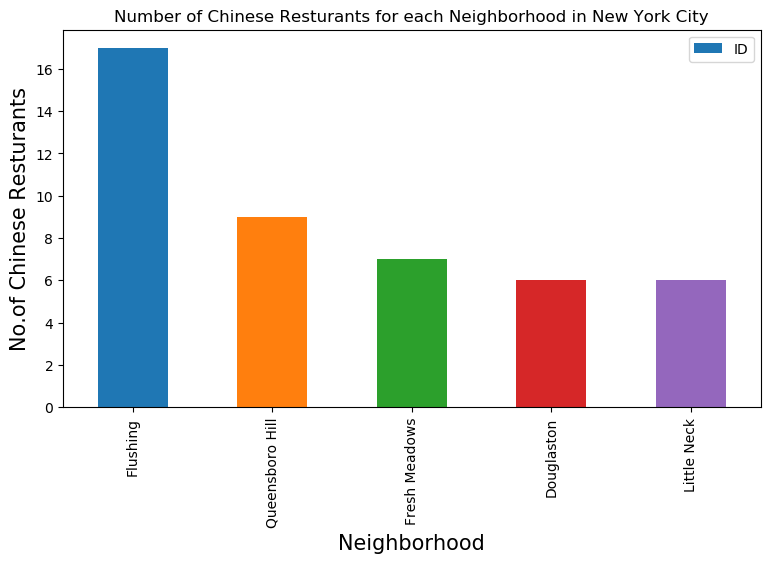

In [59]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Chinese Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Chinese Resturants', fontsize=15)
#giving a bar plot
chinese_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [60]:
chinese_rest_ny[chinese_rest_ny['Neighborhood']=='Flushing']

,Borough,Neighborhood,ID,Name
183,Queens,Flushing,5747a89b498ee4b7a5106556,DunHuang Lanzhou Beef Noodle
184,Queens,Flushing,52235ea211d2fe55782d764c,Dong Yi Feng
185,Queens,Flushing,4fa3f81be4b0a34ac673bf1e,Taipei Hong 台北夯
186,Queens,Flushing,4abfef82f964a520179320e3,New Imperial Palace 東湖
187,Queens,Flushing,4ad50f59f964a520950121e3,Fu Run 賦潤東北美食
188,Queens,Flushing,4a1845c8f964a52092791fe3,Asian Jewels Seafood Restaurant 敦城海鲜酒家
189,Queens,Flushing,4faff7eae4b03b8055801cde,Xi'an Famous Foods
190,Queens,Flushing,4ef37491d3e32dc398c7c5c7,Laoma Mala Tang
191,Queens,Flushing,5990ab0a826444188d18dabc,Szechuan House
192,Queens,Flushing,4c78756397028cfaec16d8fe,New Golden Szechuan Chinese Restaurant


In [61]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
chinese_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in chinese_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(chinese_rest_ny),')','processed')
    chinese_rest_stats_ny = chinese_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4edbac4e775bcc53fc0ed5f8
( 1 / 407 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4c3de66616ca95215b17bc7f
( 2 / 407 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4e4df7abbd4101d0d79f476b
( 3 / 407 ) processed
                         ID            Name  Likes  Rating  Tips
0  4c66dcfaaebea593955a74d0  Chinese Buffet      7     4.9    10
( 4 / 407 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4f5543a7e4b0ac8e5378b9de
( 5 / 407 ) processed
                         ID           Name  Likes  Rating  Tips
0  4b2286f1f964a5205a4824e3  Hunan Balcony     13     6.5     7
( 6 / 407 ) processed
                         ID           Name  Likes  Rating  Tips
0  4b2286f1f964a5205a4824e3  Hunan Balcony     13     6.5     7
( 7 / 407 

KeyError: 'venue'

In [62]:
chinese_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Wakefield,0,0,0,0,0
1,Bronx,Wakefield,0,0,0,0,0
2,Bronx,Co-op City,0,0,0,0,0
3,Bronx,Co-op City,4c66dcfaaebea593955a74d0,Chinese Buffet,7,4.9,10
4,Bronx,Fieldston,0,0,0,0,0


In [63]:
chinese_rest_stats_ny.shape

(50, 7)

In [64]:
chinese_rest_stats_ny.to_csv('chinese_rest_stats_ny.csv', index=False)

In [65]:
chinese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
Borough         50 non-null object
Neighborhood    50 non-null object
ID              50 non-null object
Name            50 non-null object
Likes           50 non-null object
Rating          50 non-null object
Tips            50 non-null object
dtypes: object(7)
memory usage: 2.8+ KB


In [70]:
chinese_rest_stats_ny['Likes']=chinese_rest_stats_ny['Likes'].astype('float64')
chinese_rest_stats_ny['Tips']=chinese_rest_stats_ny['Tips'].astype('float64')
chinese_rest_stats_ny['Rating']=chinese_rest_stats_ny['Rating'].astype('float64')

In [71]:
chinese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
Borough         50 non-null object
Neighborhood    50 non-null object
ID              50 non-null object
Name            50 non-null object
Likes           50 non-null float64
Rating          50 non-null float64
Tips            50 non-null float64
dtypes: float64(3), object(4)
memory usage: 2.8+ KB


In [72]:
chinese_rest_stats_ny.iloc[chinese_rest_stats_ny['Likes'].idxmax()]

Borough                            Bronx
Neighborhood                   Riverdale
ID              4b2286f1f964a5205a4824e3
Name                       Hunan Balcony
Likes                                 13
Rating                               6.5
Tips                                   7
Name: 5, dtype: object

In [73]:
chinese_rest_stats_ny.iloc[chinese_rest_stats_ny['Rating'].idxmax()]

Borough                                  Bronx
Neighborhood                      High  Bridge
ID                    4d9a695ee5fd6ea8e3096df5
Name            Lucky House Chinese Restaurant
Likes                                        5
Rating                                     7.6
Tips                                         2
Name: 26, dtype: object

In [74]:
chinese_rest_stats_ny.iloc[chinese_rest_stats_ny['Tips'].idxmax()]

Borough                            Bronx
Neighborhood                  Co-op City
ID              4c66dcfaaebea593955a74d0
Name                      Chinese Buffet
Likes                                  7
Rating                               4.9
Tips                                  10
Name: 3, dtype: object

In [75]:
ny_neighborhood_stats=chinese_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [76]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
9,High Bridge,7.6
8,Fordham,7.5
19,Parkchester,7.3
26,Spuyten Duyvil,6.5
18,Norwood,6.5
1,Bedford Park,6.5
11,Kingsbridge,6.5
23,Riverdale,6.5
2,City Island,6.2
17,North Riverdale,5.6


In [77]:
ny_borough_stats=chinese_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [78]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
0,Bronx,2.010204
1,Manhattan,0.000000


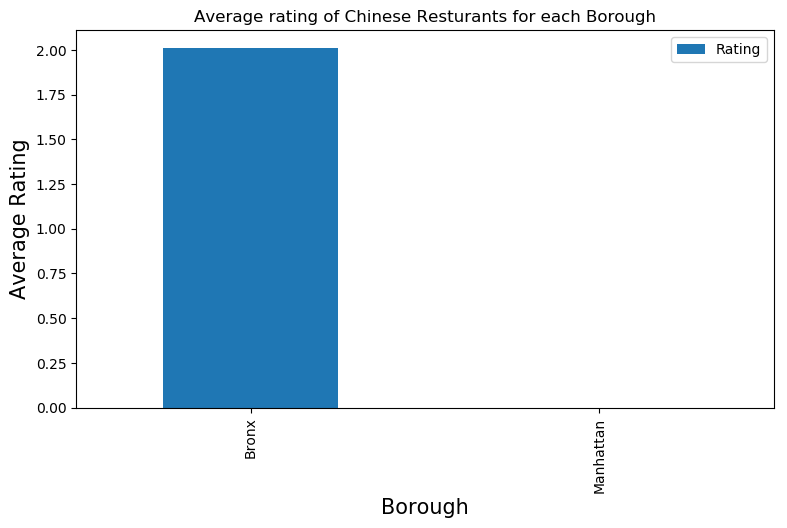

In [80]:

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Chinese Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
chinese_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()